### Basic stats and probability reminders

In [3]:
from IPython.display import Math, display
from IPython.display import Image
from IPython.core.display import HTML 

In [9]:
# expected value
display(Math('E(x)=\mu'))

<IPython.core.display.Math object>

Let x be a random variable with a finite nuber of finite outcomes x1, x2 ... xk occring with probabilities p1,p2,...pk. The E(x) expected value of x is defined as:

In [19]:
display(Math('E(x)=\sum x_{i} p_{i}'))
display(Math('p_{i} \\text{being the probability that X takes the value} x_{i}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The outcomes can be {1,2,3,4,5,6}The E(x) expected value of x is:

In [11]:
display(Math('1\\frac{1}{6} + 2\\frac{1}{6} + 3\\frac{1}{6} + 4\\frac{1}{6} + 5\\frac{1}{6} + 6\\frac{1}{6} = 3.5'))

<IPython.core.display.Math object>

The roulette game consists of a wheel with 38 numbered pockets. Let x represent the outcome of 1$ on a single number.

<span class="tex2jax_ignore">E(x) = $1*37/38 + $35*1/38 = $-0.0526</span>

In [12]:
# Variance is always positive. The variance of an x 
# random variable is the expected value of the squared deviations of variables from the mean
display(Math('\\text{Variance }\sigma^²=[(x-\mu)²]'))

<IPython.core.display.Math object>

In [13]:
display(Math('\\text{Covariance } Cov(x,y)= E[(x-\mu)(y-\mu)]'))

<IPython.core.display.Math object>

There is one issue when dealing with covariance: <br>
    <li>It is a dimensional measure
    <li>It is not normalized so it is hard to compare datasets with large differences in spread

The graph below shows why covariance wouldn't be a fit to compare the evolution of the following stock prices. Eventhough the TSLA stock was very volatile, it is not visible because the absolute value of the most expensive stock (MSFT) erases the amplitude of TSLA, relatively to MSFT's price variations.

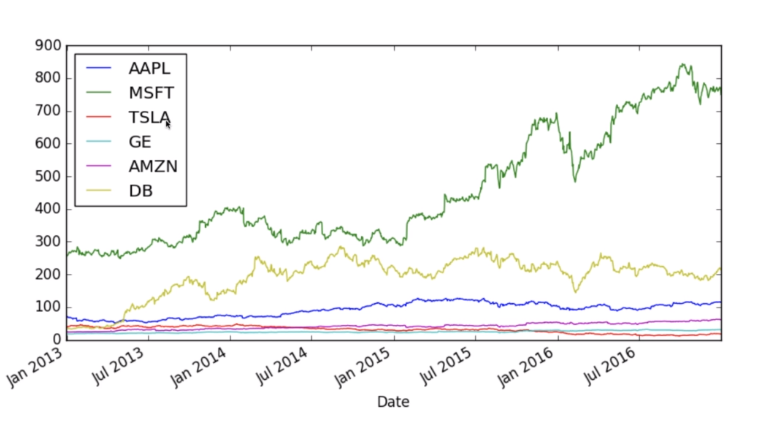

In [40]:
PATH = "/home/nesov/Desktop/"
Image(filename = PATH + "stocks_var.png", width=800, height=600)

Correlation is a response to this non-comparability. It is a dimensionless measure of how two random variables vary together.

In [45]:
display(Math('\\text{Correlation } \delta(x,y)= E[(\\frac{(x-\mu)(y-\mu)}{\sigma_x\sigma_y})]'))

<IPython.core.display.Math object>

### Markowitz-Model: Portfolio optimization model

It assists in the selection of the most **efficient** portfolio by considering various possible portfolios of the given securities based on expected return (mean) and risk (variance).<br>
What does **"efficient"** mean?

<li>It assumes normality
<li>Investors are risk-averse: investors will take on more risk if they expect more returns

<br>
    
The **"efficient**" portfolio is the portfolio that has the highest reward for a given level of risk or the lowest risk for a given return

### Markowitz model implementation

**if yfinance json decode error thrown:**

<li>pip uninstall yfinance
<li>pip uninstall pandas-datareader
<li>pip install yfinance --upgrade --no-cache-dir
<li>pip install pandas-datareader

In [44]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252
# we will generate random w (different portfolios)
NUM_PORTFOLIOS = 10000

# stocks we are going to handle
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

# historical data - define START and END dates
start_date = '2010-01-01'
end_date = '2017-01-01'


def download_data():
    # name of the stock (key) - stock values (2010-1017) as the values
    stock_data = {}

    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

    return pd.DataFrame(stock_data)


def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()


def calculate_return(data):
    # NORMALIZATION - to measure all variables in comparable metric
    log_return = np.log(data / data.shift(1))
    return log_return[1:]


def show_statistics(returns):
    # instead of daily metrics we are after annual metrics
    # mean of annual return
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)


def show_mean_variance(returns, weights):
    # we are after the annual return
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    print("Expected portfolio mean (return): ", portfolio_return)
    print("Expected portfolio volatility (standard deviation): ", portfolio_volatility)


def show_portfolios(returns, volatilities):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()


def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)


def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                            * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility,
                     portfolio_return / portfolio_volatility])


# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]


# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
    # the sum of weights is 1
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                 , method='SLSQP', bounds=bounds, constraints=constraints)


def print_optimal_portfolio(optimum, returns):
    print("Optimal portfolio: ", optimum['x'].round(3))
    print("Expected return, volatility and Sharpe ratio: ",
          statistics(optimum['x'].round(3), returns))


def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(10, 6))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


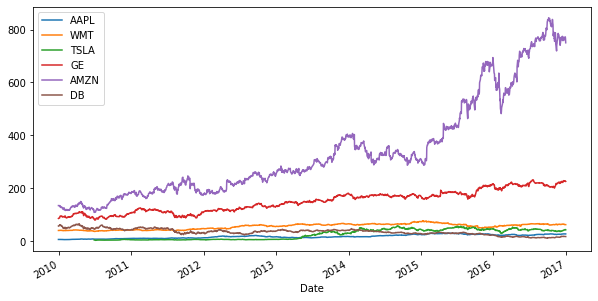

AAPL    0.206055
WMT     0.062397
TSLA    0.336881
GE      0.138247
AMZN    0.245734
DB     -0.170075
dtype: float64
          AAPL       WMT      TSLA        GE      AMZN        DB
AAPL  0.068786  0.009883  0.029641  0.021892  0.027784  0.036345
WMT   0.009883  0.026715  0.010949  0.013052  0.010737  0.020209
TSLA  0.029641  0.010949  0.274985  0.027283  0.047326  0.052331
GE    0.021892  0.013052  0.027283  0.047408  0.025799  0.054865
AMZN  0.027784  0.010737  0.047326  0.025799  0.104041  0.045003
DB    0.036345  0.020209  0.052331  0.054865  0.045003  0.175788


In [45]:


dataset = download_data()
show_data(dataset)
log_daily_returns = calculate_return(dataset)
show_statistics(log_daily_returns)

weights, means, risks = generate_portfolios(log_daily_returns)

# AAPL: 15% annually on average
# Regarding covariance matrix below, covariance of a stock with itself is simply variance.

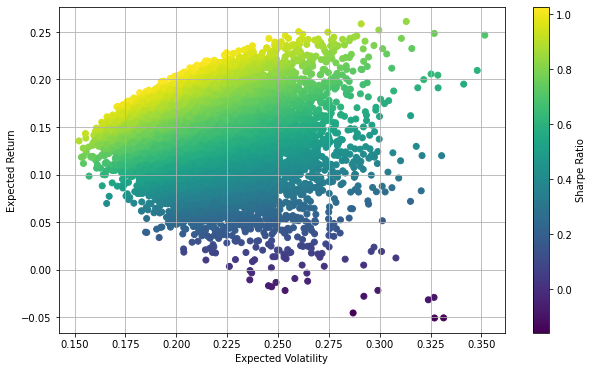

In [47]:
show_portfolios(means, risks)


Sharpe Ratio:
Describes how much excess return you are receiving for extra volatility that you endure holding a riskier asset (stock).
A Sharpe-ratio of S(x) > 1 is considered to be good

In [10]:
display(Math('S(x)=\\frac{r_x-R_f}{\sigma(x)}'))
display(Math('S(x)=\\frac{r_x-R_f}{\sigma(x)}'))
display(Math('S(x)=\\frac{r_x-R_f}{\sigma(x)}'))

<IPython.core.display.Math object>